## Example 8: Multi-model simulation

In this example we show how to work with multiple models using the same code for each.

To let the script know which variables have particular meanings (e.g. which is the membrane potential), we've added _labels_ (for outputs) and _bindings_ (a silly name for inputs) to each model.

We place the following requirements on the models:

- Each must have a meta data property `name` with a simple model name.
- Each must have its membrane potential variable labelled as `membrane_potential`.
- Each must have its L-type calcium current (all species and compartments combined) labelled as `ICaL`.
- Each must contain a variable labelled `gCaL`, that can be scaled to scale `ICaL`.
- If a model has modes/switches, it must be in baseline mode (no disease models etc.) and set to epicardial cells (if possible).

We also assume that each `mmt` file contains

Using the assumptions, in the example below we:

- iterate over a list of model file names
- load the model and protocol from each file
- obtain the membrane potential and ICaL variable from each model
- run a 1Hz simulation to obtain the baseline action potential duration (APD)
- modify the ICaL in the model to be half its size, run another simulation and measure the APD again


In [1]:
import os

import myokit

models = [
    'priebe-1998.mmt',
    'iyer-2004.mmt',
    'tentusscher-2004.mmt',
    'tentusscher-2006.mmt',
    'priebe-1998.mmt',
    'grandi-2010.mmt',
    'ohara-2011.mmt',
    'ohara-cipa-v1-2017.mmt',
]

# This will be used to store the results
names = []
delta_apds = []

# Iterate over the list of models
for filename in models:
    path = os.path.join('models', 'c', filename)
    model, protocol, _ = myokit.load(path)
    
    # Show the loaded model's name
    name = model.meta['name']
    names.append(name)
    print('Loaded ' + name)

    # Find the membrane potential, the l-type calcium current,
    # and a variable that scales it.
    # Instead of using .label, we use .labelx, which will raise
    # an exception if model doesn't contain the label.
    vm = model.labelx('membrane_potential')
    ical = model.labelx('ICaL')
    gcal = model.labelx('gCaL')

    # Obtain the duration of a stimulus pulse from the embedded protocol
    duration = protocol.head().duration()
    # ...and use it to create a new protocol with cycle length 1000ms
    protocol = myokit.pacing.blocktrain(1000, duration)
 
    # Create a simulation
    s = myokit.Simulation(model, protocol)

    # Pre-pace the model for 50 beats
    print('  Pre-pacing...')
    #s.pre(50 * 1000)
   
    # Measure the baseline APD at V=-70mV
    print('  Measuring baseline apd...')
    x, apds = s.run(1000, log=myokit.LOG_NONE, apd_variable=vm, apd_threshold=-70)

    # The returned object `apds` contains more info that we need, extract only
    # the duration of the first AP
    apd_baseline = apds['duration'][0]

    # Update the model, reducing ICaL to 50%
    ical.set_rhs(myokit.Multiply(ical.rhs(), myokit.Number(0.5)))
    
    # Scale the L-type calcium current
    s.set_constant(gcal, 0.5 * gcal.rhs().value())
    
    # Measure the new apd
    print('  Measuring modified apd...')
    s.reset()
    x, apds = s.run(
        1000, log=myokit.LOG_NONE, apd_variable=vm, apd_threshold=-70)
    apd_modified = apds['duration'][0]

    # Store the difference between the APDs
    delta = apd_modified - apd_baseline
    delta_apds.append(delta)
    print(f'  Difference: {delta} ms')


Loaded priebe-1998
  Pre-pacing...
  Measuring baseline apd...
  Measuring modified apd...
  Difference: -57.03690247866763 ms
Loaded iyer-2004
  Pre-pacing...
  Measuring baseline apd...
  Measuring modified apd...
  Difference: -90.15790640803968 ms
Loaded tentusscher-2004
  Pre-pacing...
  Measuring baseline apd...
  Measuring modified apd...
  Difference: -55.342723760400816 ms
Loaded tentusscher-2006
  Pre-pacing...
  Measuring baseline apd...
  Measuring modified apd...
  Difference: -50.4367058138055 ms
Loaded priebe-1998
  Pre-pacing...
  Measuring baseline apd...
  Measuring modified apd...
  Difference: -57.03690247866763 ms
Loaded grandi-2010
  Pre-pacing...
  Measuring baseline apd...
  Measuring modified apd...
  Difference: -58.90907637623076 ms
Loaded ohara-2011
  Pre-pacing...
  Measuring baseline apd...
  Measuring modified apd...
  Difference: -27.072142655352792 ms
Loaded li-2017
  Pre-pacing...
  Measuring baseline apd...
  Measuring modified apd...
  Difference: -3

Next, we create a bar graph of the results:

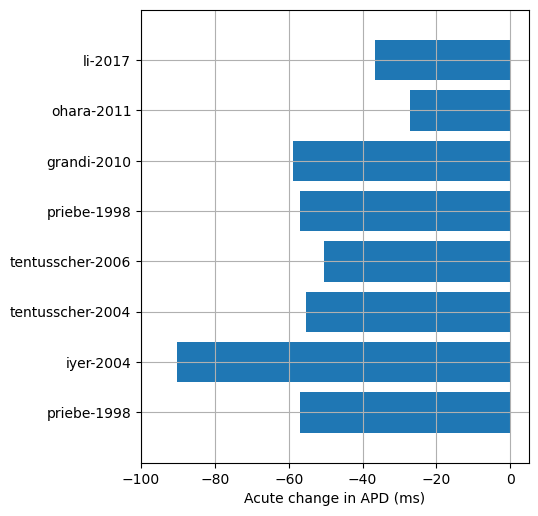

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 6), dpi=100)
ax = fig.add_subplot()
ax.set_xlabel('Acute change in APD (ms)')
ax.set_xlim(-100, 5)
ax.set_ylim(-1, len(models))
ax.grid(True)

positions = list(range(len(models)))
ax.set_yticks(positions, names)
ax.barh(positions, delta_apds)

plt.show()

Note that we could have gone a lot further here.

For example, we made the implicit assumption that all models used milliseconds, but we could have checked this (e.g. with [model.time()](https://myokit.readthedocs.io/en/stable/api_core/Model.html#myokit.Model.time) and [variable.unit()](https://myokit.readthedocs.io/en/stable/api_core/Variable.html?highlight=convert_unit#myokit.Variable.unit)) and converted if necessary (with [variable.convert_unit()](https://myokit.readthedocs.io/en/stable/api_core/Variable.html?highlight=convert_unit#myokit.Variable.convert_unit)),

Another tacit assumption was that `gCaL` pointed to a variable with a literal value, so that it could be changed with [Simulation.set_constant](https://myokit.readthedocs.io/en/stable/api_simulations/Simulation.html#myokit.Simulation.set_constant).
Alternatively, we could have forced the variable to become a constant (e.g. `gCaL.set_rhs(gCaL.rhs().eval())`) or even modified the model and created a new simulation (e.g. `gCaL.set_rhs(myokit.Multiply(myokit.Number(0.5), gCaL.rhs()))`).

A project that incorporates similar ideas in an organised way, is the [Cardiac Electrophysiology Web Lab](https://chaste.cs.ox.ac.uk/WebLab).